Google Colab demo for:

# SPIN - SMPL oPtimization IN the loop

```
@inproceedings{kolotouros2019spin,
  title={Learning to Reconstruct 3{D} Human Pose and Shape via Model-fitting in the Loop},
  author={Kolotouros, Nikos and Pavlakos, Georgios and Black, Michael J and Daniilidis, Kostas},
  booktitle={ICCV},
  year={2019}
}
```

Github Repo: https://github.com/nkolot/SPIN

Paper: https://arxiv.org/pdf/1909.12828.pdf

In [1]:
# Copy SPIN repo
!git clone https://github.com/nkolot/SPIN.git
%cd SPIN
!git checkout origin/cuda11_fix

Cloning into 'SPIN'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 206 (delta 82), reused 74 (delta 69), pack-reused 92 (from 1)
Receiving objects: 100% (206/206), 1.97 MiB | 1.50 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/SPIN
Note: switching to 'origin/cuda11_fix'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 3dcd85d Add colab demo


In [1]:
!python --version

Python 3.10.12


In [3]:
# # Install pytorch
# !pip install torch torchvision
# # Install the rest of the dependencies
!pip install -r requirements.txt
!pip install dill

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached PyOpenGL-3.1.7-py3-none-any.whl.metadata (3.2 kB)
  Using cached pyrender-0.1.45-py3-none-any.whl.metadata (1.5 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached smplx-0.1.28-py3-none-any.whl.metadata (10 kB)
  Using cached spacepy-0.7.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached trimesh-4.5.3-py3-none-any.whl.metadata (18 kB)
  Using cached freetype_py-2.5.1-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.3 kB)
  Using cached imageio-2.36.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached pyglet-2.0.18-py3-none-any.whl.metadata (7.9 kB)
  Using cached PyOpenGL-3.1.0.zip (2.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached tifffile-2024.9.20-py3-

In [4]:
# Get SPIN data
!sh fetch_data.sh

--2024-12-02 01:56:57--  http://visiondata.cis.upenn.edu/spin/data.tar.gz
Resolving visiondata.cis.upenn.edu (visiondata.cis.upenn.edu)... 158.130.68.16
Connecting to visiondata.cis.upenn.edu (visiondata.cis.upenn.edu)|158.130.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://visiondata.cis.upenn.edu/spin/data.tar.gz [following]
--2024-12-02 01:56:57--  https://visiondata.cis.upenn.edu/spin/data.tar.gz
Connecting to visiondata.cis.upenn.edu (visiondata.cis.upenn.edu)|158.130.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14960640 (14M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  14.27M  4.53MB/s    in 3.1s    

2024-12-02 01:57:01 (4.53 MB/s) - ‘data.tar.gz’ saved [14960640/14960640]

data/
data/J_regressor_h36m.npy
data/cube_parts.npy
data/train.h5
data/vertex_texture.npy
data/smpl_mean_params.npz
data/J_regressor_extra.npy
data/gmm_08.pkl
--2024-12

In [8]:
# Get SMPL
import inspect

if not hasattr(inspect, 'getargspec'):
    inspect.getargspec = inspect.getfullargspec

from invoke import task

@task
def say_hello(c):
    print("Hello, World!")

In [9]:
def convert_pkl(old_pkl, new_pkl):
    """
    Convert a Python 2 pickle to Python 3
    """
    import dill
    import pickle

    # Convert Python 2 "ObjectType" to Python 3 object
    dill._dill._reverse_typemap["ObjectType"] = object

    # Open the pickle using latin1 encoding
    with open(old_pkl, "rb") as f:
        loaded = pickle.load(f, encoding="latin1")

    # Re-save as Python 3 pickle
    with open(new_pkl, "wb") as outfile:
        pickle.dump(loaded, outfile)

!wget https://github.com/classner/up/raw/821a390fbf87a522fb327fc46736eda0326e2a06/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
%mkdir -p data/smpl/
convert_pkl('basicModel_neutral_lbs_10_207_0_v1.0.0.pkl', 'data/smpl/SMPL_NEUTRAL.pkl')

--2024-12-02 02:03:38--  https://github.com/classner/up/raw/821a390fbf87a522fb327fc46736eda0326e2a06/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/classner/up/821a390fbf87a522fb327fc46736eda0326e2a06/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl [following]
--2024-12-02 02:03:38--  https://raw.githubusercontent.com/classner/up/821a390fbf87a522fb327fc46736eda0326e2a06/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39001280 (37M) [application/octet-stream]
Saving to: 

/tmp/ipykernel_636287/2678452343.py:13: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  loaded = pickle.load(f, encoding="latin1")


In [11]:
# Run demo
# !python3 demo.py --checkpoint=data/model_checkpoint.pt --img=examples/im1010.jpg --openpose=examples/im1010_openpose.json --bbox=examples/im1010_bbox.json
# !python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_11-23_11_41.pt --img=examples/im1010.jpg --openpose=examples/im1010_openpose.json --bbox=examples/im1010_bbox.json
# !python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_12-22_45_38.pt --img=examples/11412_r.jpg
!python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_12-18_26_14.pt --img=examples/11403_l.jpg
!python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_12-18_26_14.pt --img=examples/11412_l.jpg
!python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_12-18_26_14.pt --img=examples/1757_r.jpg
!python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_12-18_26_14.pt --img=examples/1784_l.jpg
!python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_12-18_26_14.pt --img=examples/1840_l.jpg
!python3 demo.py --checkpoint=logs/train_example/checkpoints/2024_12_12-18_26_14.pt --img=examples/1936_l.jpg
# ! pip install tensorboard


/home/mohamed/miniconda3/envs/pose/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohamed/miniconda3/envs/pose/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mohamed/repos/pose_estimation_task/SPIN/demo.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.co

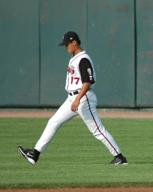

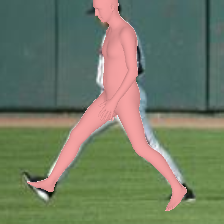

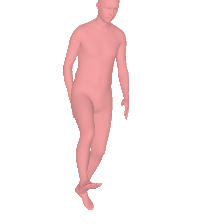

In [4]:
# Visualize data
from IPython.display import Image, display
display(Image('examples/im1010.jpg'))
display(Image('examples/im1010_shape.png'))
display(Image('examples/im1010_shape_side.png'))

In [12]:
import torch

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")


Device 0: NVIDIA GeForce GTX 1060 with Max-Q Design
